# NBA Predictions by Imran Khan

In this notebook, I am going to create a model to predict the outcome of NBA regular season games. State-of-the-art methods are able to predict outcomes with around 75% accuracy, while non-technical experts have an accuracy around 70%. My targets, going into the project, were to create a model that could rival non-technical experts. I quickly found that this was no easy task, but I had a lot of fun messing around with different techniques.



## Data

I collected data from www.basketball-reference.com. The site provides data on everything about the NBA players, games, and teams. However, I needed to be sure to only use data available at the time of a prediction, which is a crucial factor if the model were to move into a production environment. Because of this constraint, I was limited to only using historical data for prediction. The historical data on basketball-reference included score records and standings/team statistics from any point in history. The site offers downloadable files for use, but I wanted to have a completely automated process, so I built a scraper to collect the data in real time.

## Code

In [1]:
#Imports

from IPython.display import HTML
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import urllib.request
import re 
import datetime
from datetime import timedelta
import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.cross_validation import KFold, ShuffleSplit
from numpy import mean
from sklearn.preprocessing import LabelEncoder

import sys
%matplotlib inline
import seaborn as sns

### Web Scraping

I started this by creating a couple of helper functions.

In [2]:
def read_page(data_url):
#Takes a url and returns the source html

    req = urllib.request.Request(data_url)
    with urllib.request.urlopen(req) as response:
       the_page = response.read()
    return the_page

In [3]:
def checkdate(month,day,year):
#checks if a date is valid and not in the future
    try:
        if datetime.datetime(year=year,month=month,day=day) > datetime.datetime.now():
           return False
        return True
    except ValueError:
        return False
checkdate(3,13,2018)

True

I start by storing tables about schedule and results for every team

In [4]:
def find_common_name(x):
#Transforms "Golden State Warriors" to "Golden State"
    if x=="Los Angeles Lakers":
        return "LA Lakers"
    elif x=="Los Angeles Clippers":
        return "LA Clippers"
    elif x=="Portland Trail Blazers":
        return "Portland"
    else:
        return " ".join(x.split(" ")[:-1])

In [5]:
def changestreak(x):
#Transforms a win streak when read in as "W 1" to 1 or "L 3" to -1
    if(x[0] == "W"):
        return int(x.split(" ")[-1])
    else:
        return -1*int(x.split(" ")[-1])

In [6]:
def create_team_table(url):
#Reads html file of team schedule to a pandas DataFrame

    sys.stdout.write("\r\x1b[K" + "reading from "+ str(url))
    
    games = str(read_page(url))
    games = games.split(";year")
    games = games[1:]
    games[0]    

    pattern = "=201(7|8)\">(?P<date>[,a-zA-Z0-9\s]+)</a>.*data-stat=\"game_location\" >((?P<home>[@]?)).*201(7|8).html\">(?P<opponent>[a-zA-Z0-9\s]+)</a></td><td class=\"center \" data-stat=\"game_result\" >(?P<winloss>[a-zA-Z0-9\s]+)</td><td class=\"center \" data-stat=\"overtimes\" ></td><td class=\"right \" data-stat=\"pts\" >(?P<pts>[a-zA-Z0-9\s]+)</td><td class=\"center \" data-stat=\"opp_pts\" >(?P<opp_pts>[a-zA-Z0-9\s]+)</td><td class=\"center \" data-stat=\"wins\" >(?P<wins>[a-zA-Z0-9\s]+)</td><td class=\"center \" data-stat=\"losses\" >(?P<losses>[a-zA-Z0-9\s]+)</td><td class=\"left \" data-stat=\"game_streak\" >(?P<game_streak>[a-zA-Z0-9\s]+)"
    pattern_matcher = re.compile(pattern)
    matches = [pattern_matcher.findall(games[i]) for i in range(len(games))]

    matches = [[datetime.datetime.strptime(i[0][1],"%a, %b %d, %Y"),int(i[0][2]==""),find_common_name(i[0][5]),i[0][6],i[0][7],i[0][8],i[0][9],i[0][10],i[0][11]] for i in matches if len(i)>0]
    df = pd.DataFrame(matches)
    df.columns = ["Date","Home","Opponent","Result","TeamScore","OpponentScore","Wins","Losses","Streak"]
    df["Streak"] = df["Streak"].apply(lambda x: changestreak(x))
    return df

In [7]:
#reading in all the schedule data for every team and creating a dictionary to store them for easy access

Atlanta = create_team_table("https://www.basketball-reference.com/teams/ATL/2018_games.html")
Boston = create_team_table("https://www.basketball-reference.com/teams/BOS/2018_games.html")
Brooklyn = create_team_table("https://www.basketball-reference.com/teams/BRK/2018_games.html")
Charlotte = create_team_table("https://www.basketball-reference.com/teams/CHO/2018_games.html")
Chicago = create_team_table("https://www.basketball-reference.com/teams/CHI/2018_games.html")
Cleveland = create_team_table("https://www.basketball-reference.com/teams/CLE/2018_games.html")
Dallas = create_team_table("https://www.basketball-reference.com/teams/DAL/2018_games.html")
Denver = create_team_table("https://www.basketball-reference.com/teams/DEN/2018_games.html")
Detroit = create_team_table("https://www.basketball-reference.com/teams/DET/2018_games.html")
GoldenState = create_team_table("https://www.basketball-reference.com/teams/GSW/2018_games.html")
Houston = create_team_table("https://www.basketball-reference.com/teams/HOU/2018_games.html")
Indiana = create_team_table("https://www.basketball-reference.com/teams/IND/2018_games.html")
LAC = create_team_table("https://www.basketball-reference.com/teams/LAC/2018_games.html")
LAL = create_team_table("https://www.basketball-reference.com/teams/LAL/2018_games.html")
Memphis = create_team_table("https://www.basketball-reference.com/teams/MEM/2018_games.html")
Miami = create_team_table("https://www.basketball-reference.com/teams/MIA/2018_games.html")
Milwaukee = create_team_table("https://www.basketball-reference.com/teams/MIL/2018_games.html")
Minnesota = create_team_table("https://www.basketball-reference.com/teams/MIN/2018_games.html")
NewOrleans = create_team_table("https://www.basketball-reference.com/teams/NOP/2018_games.html")
NewYork = create_team_table("https://www.basketball-reference.com/teams/NYK/2018_games.html")
OklahomaCity = create_team_table("https://www.basketball-reference.com/teams/OKC/2018_games.html")
Orlando = create_team_table("https://www.basketball-reference.com/teams/ORL/2018_games.html")
Philadelphia = create_team_table("https://www.basketball-reference.com/teams/PHI/2018_games.html")
Phoenix = create_team_table("https://www.basketball-reference.com/teams/PHO/2018_games.html")
Portland = create_team_table("https://www.basketball-reference.com/teams/POR/2018_games.html")
Sacramento = create_team_table("https://www.basketball-reference.com/teams/SAC/2018_games.html")
SanAntonio = create_team_table("https://www.basketball-reference.com/teams/SAS/2018_games.html")
Toronto = create_team_table("https://www.basketball-reference.com/teams/TOR/2018_games.html")
Utah = create_team_table("https://www.basketball-reference.com/teams/UTA/2018_games.html")
Washington = create_team_table("https://www.basketball-reference.com/teams/WAS/2018_games.html")

sys.stdout.write("\r\x1b[K" + "done                                                                     ")
teamtables = {"Atlanta":Atlanta,"Boston":Boston,"Brooklyn":Brooklyn,"Charlotte":Charlotte,"Chicago":Chicago,"Cleveland":Cleveland,"Dallas":Dallas,"Denver":Denver,"Detroit":Detroit,"Golden State":GoldenState,"Houston":Houston,"Indiana":Indiana,"LA Clippers":LAC,"LA Lakers":LAL,"Memphis":Memphis,"Miami":Miami,"Milwaukee":Milwaukee,"Minnesota":Minnesota,"New Orleans":NewOrleans,"New York":NewYork,"Oklahoma City":OklahomaCity,"Orlando":Orlando,"Philadelphia":Philadelphia,"Phoenix":Phoenix,"Portland":Portland,"Sacramento":Sacramento,"San Antonio":SanAntonio,"Toronto":Toronto,"Utah":Utah,"Washington":Washington}

done                                                                     ml

Next, I wanted to capture the information about all scores played on a particular day.

In [8]:
def find_scores(month,day,year):
#given a date, finds all the games and scores for that day
    if not checkdate(month,day,year):
        return []
    data_url = "https://www.basketball-reference.com/boxscores/?month=" + str(month) + "&day=" + str(day) + "&year=" + str(year)
    games = str(read_page(data_url))
    games = games.split("class=\"teams\"")
    games = games[1:]
    pattern = '(?P<team>[a-zA-Z0-9\s]+)</a></td>\\\\n\\\\t\\\\t\\\\t<td class=\"right\">(?P<score>[0-9]+)'
    pattern_matcher = re.compile(pattern)
    return [pattern_matcher.findall(games[i]) for i in range(len(games))]
find_scores(3,9,2018)

[[('LA Lakers', '116'), ('Denver', '125')],
 [('Chicago', '83'), ('Detroit', '99')],
 [('Atlanta', '87'), ('Indiana', '112')],
 [('Cleveland', '102'), ('LA Clippers', '116')],
 [('Utah', '95'), ('Memphis', '78')],
 [('New York', '112'), ('Milwaukee', '120')],
 [('Washington', '116'), ('New Orleans', '97')],
 [('Golden State', '108'), ('Portland', '125')],
 [('Orlando', '88'), ('Sacramento', '94')],
 [('Houston', '105'), ('Toronto', '108')]]

Finally, I wanted to be able to read in the data about historical team standings

In [9]:
def find_team_opponent_stats(month,day,year):
#finds team data and team standings data for a given date
    if not checkdate(month,day,year):
        return []
    data_url = "https://www.basketball-reference.com/friv/standings.fcgi?month=" + str(month) + "&day=" + str(day) + "&year=" + str(year)
    teams = str(read_page(data_url))
    teams = teams.split("data-stat=\"ranker")
    teamstats = teams[2:32]
    opponentstats = teams[34:64]
    
    pattern = "(?P<team>[a-zA-Z0-9\s]+)</a></td><td class=\"right \" data-stat=\"g\" >(?P<g>[0-9]+)</td><td class=\"right \" data-stat=\"mp\" >(?P<mp>[0-9]+)</td><td class=\"right \" data-stat=\"fg\" >(?P<fg>[0-9]+)</td><td class=\"right \" data-stat=\"fga\" >(?P<fga>[0-9]+)</td><td class=\"right \" data-stat=\"fg_pct\" >(?P<fg_pct>[.0-9]+)</td><td class=\"right \" data-stat=\"fg3\" >(?P<fg3>[0-9]+)</td><td class=\"right \" data-stat=\"fg3a\" >(?P<fg3a>[0-9]+)</td><td class=\"right \" data-stat=\"fg3_pct\" >(?P<fg3_pct>[.0-9]+)</td><td class=\"right \" data-stat=\"fg2\" >(?P<fg2>[0-9]+)</td><td class=\"right \" data-stat=\"fg2a\" >(?P<fg2a>[0-9]+)</td><td class=\"right \" data-stat=\"fg2_pct\" >(?P<fg2_pct>[.0-9]+)</td><td class=\"right \" data-stat=\"ft\" >(?P<ft>[0-9]+)</td><td class=\"right \" data-stat=\"fta\" >(?P<fta>[0-9]+)</td><td class=\"right \" data-stat=\"ft_pct\" >(?P<ft_pct>[.0-9]+)</td><td class=\"right \" data-stat=\"orb\" >(?P<orb>[0-9]+)</td><td class=\"right \" data-stat=\"drb\" >(?P<drb>[0-9]+)</td><td class=\"right \" data-stat=\"trb\" >(?P<trb>[0-9]+)</td><td class=\"right \" data-stat=\"ast\" >(?P<ast>[0-9]+)</td><td class=\"right \" data-stat=\"stl\" >(?P<stl>[0-9]+)</td><td class=\"right \" data-stat=\"blk\" >(?P<blk>[0-9]+)</td><td class=\"right \" data-stat=\"tov\" >(?P<tov>[0-9]+)</td><td class=\"right \" data-stat=\"pf\" >(?P<pf>[0-9]+)</td><td class=\"right \" data-stat=\"pts\" >(?P<pts>[0-9]+)"
    pattern_matcher = re.compile(pattern)
    t = [pattern_matcher.findall(teamstats[i]) for i in range(len(teamstats))]
    
    pattern1 = "(?P<team>[a-zA-Z0-9\s]+)</a></td><td class=\"right \" data-stat=\"g\" >(?P<g>[0-9]+)</td><td class=\"right \" data-stat=\"mp\" >(?P<mp>[0-9]+)</td><td class=\"right \" data-stat=\"opp_fg\" >(?P<opp_fg>[0-9]+)</td><td class=\"right \" data-stat=\"opp_fga\" >(?P<opp_fga>[0-9]+)</td><td class=\"right \" data-stat=\"opp_fg_pct\" >(?P<opp_fg_pct>[.0-9]+)</td><td class=\"right \" data-stat=\"opp_fg3\" >(?P<opp_fg3>[0-9]+)</td><td class=\"right \" data-stat=\"opp_fg3a\" >(?P<opp_fg3a>[0-9]+)</td><td class=\"right \" data-stat=\"opp_fg3_pct\" >(?P<opp_fg3_pct>[.0-9]+)</td><td class=\"right \" data-stat=\"opp_fg2\" >(?P<opp_fg2>[0-9]+)</td><td class=\"right \" data-stat=\"opp_fg2a\" >(?P<opp_fg2a>[0-9]+)</td><td class=\"right \" data-stat=\"opp_fg2_pct\" >(?P<opp_fg2_pct>[.0-9]+)</td><td class=\"right \" data-stat=\"opp_ft\" >(?P<opp_ft>[0-9]+)</td><td class=\"right \" data-stat=\"opp_fta\" >(?P<opp_fta>[0-9]+)</td><td class=\"right \" data-stat=\"opp_ft_pct\" >(?P<opp_ft_pct>[.0-9]+)</td><td class=\"right \" data-stat=\"opp_orb\" >(?P<opp_orb>[0-9]+)</td><td class=\"right \" data-stat=\"opp_drb\" >(?P<opp_drb>[0-9]+)</td><td class=\"right \" data-stat=\"opp_trb\" >(?P<opp_trb>[0-9]+)</td><td class=\"right \" data-stat=\"opp_ast\" >(?P<opp_ast>[0-9]+)</td><td class=\"right \" data-stat=\"opp_stl\" >(?P<opp_stl>[0-9]+)</td><td class=\"right \" data-stat=\"opp_blk\" >(?P<opp_blk>[0-9]+)</td><td class=\"right \" data-stat=\"opp_tov\" >(?P<opp_tov>[0-9]+)</td><td class=\"right \" data-stat=\"opp_pf\" >(?P<opp_pf>[0-9]+)</td><td class=\"right \" data-stat=\"opp_pts\" >(?P<opp_pts>[0-9]+)"
    pattern_matcher1 = re.compile(pattern1)
    o = [pattern_matcher1.findall(opponentstats[i]) for i in range(len(opponentstats))]
    return [t,o]

### Building the training set

First, I define several helper functions.

In [10]:
def streak(team, month, day, year):
#returns a team's win/loss streak for a given date
    team = teamtables[team]
    team = team[team["Date"]<datetime.datetime(year,month,day)]
    return team["Streak"][len(team["Streak"])-1]

In [11]:
def wins(team, month, day, year):
#returns a team's total number of wins for a given date
    team = teamtables[team]
    team = team[team["Date"]<datetime.datetime(year,month,day)]
    return team["Wins"][len(team["Wins"])-1]

In [12]:
def losses(team, month, day, year):
#returns a team's total number of losses for a given date
    team = teamtables[team]
    team = team[team["Date"]<datetime.datetime(year,month,day)]
    return team["Losses"][len(team["Losses"])-1]

In [13]:
def homewinpct(team, month, day, year):
#returns a team's home game win percentage for a given date
    team = teamtables[team]
    team = team[team["Date"]<datetime.datetime(year,month,day)]
    team = team[team["Home"]==1]
    denom = len(team["Date"])
    try:
        return team.groupby("Result").agg("count").to_dict()["Date"]["W"]/denom
    except KeyError:
        return 0

In [14]:
def roadwinpct(team, month, day, year):
#returns a team's away game win percentage for a given date
    team = teamtables[team]
    team = team[team["Date"]<datetime.datetime(year,month,day)]
    team = team[team["Home"]==0]
    denom = len(team["Date"])
    try:
        return team.groupby("Result").agg("count").to_dict()["Date"]["W"]/denom
    except KeyError:
        return 0

In [15]:
def differential(team,month,day,year):
#returns a teams average point differential at a given date
    team = teamtables[team]
    team = team[team["Date"]<datetime.datetime(year,month,day)]
    team["differential"] = pd.to_numeric(team["TeamScore"]) - pd.to_numeric(team["OpponentScore"])
    return team["differential"].mean()


In [16]:
def homedifferential(team,month,day,year):
#returns a team's average home game point differential at a given date
    team = teamtables[team]
    team = team[team["Date"]<datetime.datetime(year,month,day)]
    team = team[team["Home"]==1]
    team["differential"] = pd.to_numeric(team["TeamScore"]) - pd.to_numeric(team["OpponentScore"])
    return team["differential"].mean()

In [17]:
def roaddifferential(team,month,day,year):
#returns a team's average away game point differential at a given date
    team = teamtables[team]
    team = team[team["Date"]<datetime.datetime(year,month,day)]
    team = team[team["Home"]==0]
    team["differential"] = pd.to_numeric(team["TeamScore"]) - pd.to_numeric(team["OpponentScore"])
    return team["differential"].mean()

In [18]:
def last_n(n,team,month,day,year):
#returns the number of wins a team has had in the last n games for a given date
    team = teamtables[team]
    team = team[team["Date"]<datetime.datetime(year,month,day)]
    if(len(team["Date"]) < n):
        n = len(team["Date"])
    team = team.iloc[len(team["Date"])-n:len(team["Date"])]
    try:
        return team.groupby("Result").agg("count").to_dict()["Date"]["W"]
    except KeyError:
        return 0
    
##An example
last_n(10,"Atlanta",3,9,2018)

3

In [19]:
def build_daily_data(month, day, year):
#builds a training set for a given day
    scores = find_scores(month, day, year)
    t,o = find_team_opponent_stats(month, day, year)
    
    if(scores == []):
        return
    
    t = [list(i[0]) for i in t]
    o = [list(i[0]) for i in o]

    t = pd.DataFrame(t)
    o = pd.DataFrame(o)

    joined = pd.merge(t,o,on=0, suffixes=('_team', '_opp'))

    scores = pd.DataFrame([[i[0][0],int(i[0][1]),i[1][0],int(i[1][1])] for i in scores])

    joined.columns = ["Name","G","MP","FG","FGA","FG%","3P","3PA","3P%","2P","2PA","2P%","FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV","PF","PTS","Opp_G","Opp_MP","Opp_FG","Opp_FGA","Opp_FG%","Opp_3P","Opp_3PA","Opp_3P%","Opp_2P","Opp_2PA","Opp_2P%","Opp_FT","Opp_FTA","Opp_FT%","Opp_ORB","Opp_DRB","Opp_TRB","Opp_AST","Opp_STL","Opp_BLK","Opp_TOV","Opp_PF","Opp_PTS"]
    joined["Name"] = joined["Name"].apply(lambda x: find_common_name(x))

    onejoin = pd.merge(scores,joined, left_on = 0, right_on = "Name")
    onejoin.columns = ["Team1","Team1Score","Team2","Team2Score","Team1Name","G1","MP1","FG1","FGA1","FG%1","3P1","3PA1","3P%1","2P1","2PA1","2P%1","FT1","FTA1","FT%1","ORB1","DRB1","TRB1","AST1","STL1","BLK1","TOV1","PF1","PTS1","Opp_G1","Opp_MP1","Opp_FG1","Opp_FGA1","Opp_FG%1","Opp_3P1","Opp_3PA1","Opp_3P%1","Opp_2P1","Opp_2PA1","Opp_2P%1","Opp_FT1","Opp_FTA1","Opp_FT%1","Opp_ORB1","Opp_DRB1","Opp_TRB1","Opp_AST1","Opp_STL1","Opp_BLK1","Opp_TOV1","Opp_PF1","Opp_PTS1"]
    twojoin = pd.merge(onejoin,joined, left_on = "Team2", right_on= "Name")
    twojoin ["outcome"] = (twojoin["Team1Score"] > twojoin["Team2Score"]).apply(lambda x: int(x))
    del twojoin["Team1Score"],twojoin["Team2Score"],twojoin["Team1Name"],twojoin["Name"]
    
    twojoin["Year"] = str(year)
    twojoin["Month"] = str(month)
    twojoin["Day"] = str(day)
    twojoin["Date"]  =datetime.datetime(year, month, day)
    g = ['Team1', 'Team2','Year', 'Month', 'Day', 'Date', 'G1', 'MP1', 'FG1', 'FGA1', 'FG%1', '3P1', '3PA1', '3P%1', '2P1', '2PA1', '2P%1', 'FT1', 'FTA1', 'FT%1', 'ORB1', 'DRB1', 'TRB1', 'AST1', 'STL1', 'BLK1', 'TOV1', 'PF1', 'PTS1', 'Opp_G1', 'Opp_MP1', 'Opp_FG1', 'Opp_FGA1', 'Opp_FG%1', 'Opp_3P1', 'Opp_3PA1', 'Opp_3P%1', 'Opp_2P1', 'Opp_2PA1', 'Opp_2P%1', 'Opp_FT1', 'Opp_FTA1', 'Opp_FT%1', 'Opp_ORB1', 'Opp_DRB1', 'Opp_TRB1', 'Opp_AST1', 'Opp_STL1', 'Opp_BLK1', 'Opp_TOV1', 'Opp_PF1', 'Opp_PTS1', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Opp_G', 'Opp_MP', 'Opp_FG', 'Opp_FGA', 'Opp_FG%', 'Opp_3P', 'Opp_3PA', 'Opp_3P%', 'Opp_2P', 'Opp_2PA', 'Opp_2P%', 'Opp_FT', 'Opp_FTA', 'Opp_FT%', 'Opp_ORB', 'Opp_DRB', 'Opp_TRB', 'Opp_AST', 'Opp_STL', 'Opp_BLK', 'Opp_TOV', 'Opp_PF', 'Opp_PTS', 'outcome']
    
    twojoin = twojoin[g]
    
    twojoin["LastOne1"] = twojoin["Team1"].apply(lambda x: last_n(1,x,month, day, year))
    twojoin["LastOne"] = twojoin["Team2"].apply(lambda x: last_n(1,x,month, day, year))
    
    twojoin["LastTwo1"] = twojoin["Team1"].apply(lambda x: last_n(2,x,month, day, year))
    twojoin["LastTwo"] = twojoin["Team2"].apply(lambda x: last_n(2,x,month, day, year))
    
    twojoin["LastFive1"] = twojoin["Team1"].apply(lambda x: last_n(5,x,month, day, year))
    twojoin["LastFive"] = twojoin["Team2"].apply(lambda x: last_n(5,x,month, day, year))
    
    twojoin["LastTen1"] = twojoin["Team1"].apply(lambda x: last_n(10,x,month, day, year))
    twojoin["LastTen"] = twojoin["Team2"].apply(lambda x: last_n(10,x,month, day, year))
    
    twojoin["LastTwenty1"] = twojoin["Team1"].apply(lambda x: last_n(20,x,month, day, year))
    twojoin["LastTwenty"] = twojoin["Team2"].apply(lambda x: last_n(20,x,month, day, year))
    
    twojoin["roaddifferential1"] = twojoin["Team1"].apply(lambda x: roaddifferential(x,month, day, year))
    twojoin["roaddifferential"] = twojoin["Team2"].apply(lambda x: roaddifferential(x,month, day, year))
    
    twojoin["homedifferential1"] = twojoin["Team1"].apply(lambda x: homedifferential(x,month, day, year))
    twojoin["homedifferential"] = twojoin["Team2"].apply(lambda x: homedifferential(x,month, day, year))
    
    twojoin["differential1"] = twojoin["Team1"].apply(lambda x: differential(x,month, day, year))
    twojoin["differential"] = twojoin["Team2"].apply(lambda x: differential(x,month, day, year))
    
    twojoin["roadwinpct1"] = twojoin["Team1"].apply(lambda x: roadwinpct(x,month, day, year))
    twojoin["roadwinpct"] = twojoin["Team2"].apply(lambda x: roadwinpct(x,month, day, year))
    
    twojoin["losses1"] = twojoin["Team1"].apply(lambda x: losses(x,month, day, year))
    twojoin["losses"] = twojoin["Team2"].apply(lambda x: losses(x,month, day, year))
    
    
    twojoin["wins1"] = twojoin["Team1"].apply(lambda x: wins(x,month, day, year))
    twojoin["wins"] = twojoin["Team2"].apply(lambda x: wins(x,month, day, year))
    
    twojoin["streak1"] = twojoin["Team1"].apply(lambda x: streak(x,month, day, year))
    twojoin["streak"] = twojoin["Team2"].apply(lambda x: streak(x,month, day, year))
       
    
    return twojoin

## An example
build_daily_data(11,3,2017)

,Team1,Team2,Year,Month,Day,Date,G1,MP1,FG1,FGA1,...,differential1,differential,roadwinpct1,roadwinpct,losses1,losses,wins1,wins,streak1,streak
0,Houston,Atlanta,2017,11,3,2017-11-03,9,2160,329,747,...,3.444444,-8.250000,0.833333,0.166667,3,7,6,1,1,-7
1,New Orleans,Dallas,2017,11,3,2017-11-03,8,1920,318,686,...,-1.875000,-10.111111,0.500000,0.000000,5,8,3,1,-2,-4
2,Miami,Denver,2017,11,3,2017-11-03,7,1705,282,608,...,-1.500000,1.875000,0.000000,0.400000,4,4,3,4,1,1
3,Milwaukee,Detroit,2017,11,3,2017-11-03,8,1920,314,649,...,-2.375000,2.250000,0.666667,0.600000,4,3,4,5,-2,-1
4,Brooklyn,LA Lakers,2017,11,3,2017-11-03,8,1920,323,734,...,-4.125000,-4.000000,0.000000,0.333333,5,5,3,3,-3,-1
5,Phoenix,New York,2017,11,3,2017-11-03,8,1920,307,691,...,-9.250000,-3.142857,0.500000,0.333333,4,4,4,3,2,-1
6,Boston,Oklahoma City,2017,11,3,2017-11-03,8,1920,296,667,...,9.250000,10.857143,0.750000,0.500000,2,3,6,4,6,2
7,Chicago,Orlando,2017,11,3,2017-11-03,6,1440,199,512,...,-11.166667,8.125000,0.000000,0.600000,5,2,1,6,-2,2
8,Indiana,Philadelphia,2017,11,3,2017-11-03,8,1920,336,695,...,3.750000,-2.375000,0.500000,0.600000,3,4,5,4,3,3
9,Charlotte,San Antonio,2017,11,3,2017-11-03,8,1920,305,676,...,1.875000,-3.125000,0.333333,0.400000,3,4,5,4,3,-4


In [20]:
def datetime_range(start=None, end=None):
#given a start and end date, returns a range of dates to iterate through
    span = end - start
    for i in range(span.days + 1):
        yield start + timedelta(days=i)

Finally, we can create the test set. It takes a while. Fortunately, we only have to run it once and we can reuse the data as much as we want

In [21]:
start = datetime.datetime(2017,10,20)
end = datetime.datetime(2018,3,12)
originaldata = build_daily_data(start.month,start.day, start.year)
for i in list(datetime_range(start,end)):
    sys.stdout.write("\r\x1b[K" + "building "+ i.strftime("%Y-%m-%d"))
    originaldata = pd.concat([originaldata,build_daily_data(i.month,i.day,i.year)])
sys.stdout.write("\r\x1b[K" + "done                                        ")

done                                        

Here's a sneak peak at what the data looks like

In [22]:
originaldata.head()

,Team1,Team2,Year,Month,Day,Date,G1,MP1,FG1,FGA1,...,differential1,differential,roadwinpct1,roadwinpct,losses1,losses,wins1,wins,streak1,streak
0,Orlando,Brooklyn,2017,10,20,2017-10-20,1,240,43,90,...,7.0,-9.0,0.0,0.0,0,1,1,0,1,-1
1,Atlanta,Charlotte,2017,10,20,2017-10-20,1,240,48,94,...,6.0,-12.0,1.0,0.0,0,1,1,0,1,-1
2,Sacramento,Dallas,2017,10,20,2017-10-20,1,240,42,88,...,-5.0,-6.0,0.0,0.0,1,1,0,0,-1,-1
3,Portland,Indiana,2017,10,20,2017-10-20,1,240,44,90,...,48.0,9.0,1.0,0.0,0,0,1,1,1,1
4,Cleveland,Milwaukee,2017,10,20,2017-10-20,1,240,38,83,...,3.0,8.0,0.0,1.0,0,0,1,1,1,1


### More feature engineering, data cleaning

The next few blocks create new features out of the data and make the data usable for machine learning models. I find the difference between the two teams for every feature, and use those to create my model. I created my model including the original features as well, and didn't find significant difference in the predictive power. Using Occam's razor, I decided to go with the smaller model and removed the extraneous features. I also normalize each feature. Normalizing is important for implementation in many machine learning models that I try.

In [23]:
#resets the index (for ease of use)
data = originaldata.copy()
data = data.reset_index()
del data["index"]

In [24]:
#transforms all the numbers (which are Strings) to ints
#makes a difference feature, the difference between the home team's stats and the away team's stats
#removes the original team data
for i in list(data):
    if str(i+"1") in list(data):
        data[i] = pd.to_numeric(data[i])
        data[str(i+"1")] = pd.to_numeric(data[str(i+"1")])
        data[str(i+"_diff")] = data[i] - data[str(i+"1")]
        del data[i]
        del data[str(i+"1")]

##what data looks like now
data.iloc[210:215]

,Team1,Team2,Year,Month,Day,Date,outcome,G_diff,MP_diff,FG_diff,...,LastFive_diff,LastTen_diff,LastTwenty_diff,roaddifferential_diff,homedifferential_diff,differential_diff,roadwinpct_diff,losses_diff,wins_diff,streak_diff
210,Utah,Brooklyn,2017,11,17,2017-11-17,0,-1,-265,15,...,1,0,0,5.900000,-3.222222,-1.142857,0.250000,0,-1,0
211,Charlotte,Chicago,2017,11,17,2017-11-17,0,-1,-215,-72,...,1,-2,-3,-2.285714,-17.583333,-8.909091,0.000000,2,-3,0
212,LA Clippers,Cleveland,2017,11,17,2017-11-17,0,2,480,96,...,4,3,3,4.350000,-9.910714,-3.230769,0.225000,-1,3,9
213,Minnesota,Dallas,2017,11,17,2017-11-17,1,1,215,-14,...,-2,-5,-6,-3.857143,-10.833333,-6.835897,-0.285714,8,-7,-5
214,New Orleans,Denver,2017,11,17,2017-11-17,0,-1,-265,-52,...,0,1,1,-5.190476,6.892857,1.642857,-0.238095,-1,0,0


In [25]:
#Normalizing features and filling all NA values with 0
for i in list(data):
    if data[i].dtype == "int64" or data[i].dtype == "float64":
        if(data[i].max()!=0):
            data[i] = (data[i]-data[i].min())/(data[i].max()-data[i].min())

data = data.fillna(0)

This is what the finalized training set looks like

In [26]:
data.head()

,Team1,Team2,Year,Month,Day,Date,outcome,G_diff,MP_diff,FG_diff,...,LastFive_diff,LastTen_diff,LastTwenty_diff,roaddifferential_diff,homedifferential_diff,differential_diff,roadwinpct_diff,losses_diff,wins_diff,streak_diff
0,Orlando,Brooklyn,2017,10,20,2017-10-20,0.0,0.454545,0.45539,0.529328,...,0.4,0.444444,0.464286,0.000000,0.000000,0.2875,0.5,0.508197,0.491525,0.435897
1,Atlanta,Charlotte,2017,10,20,2017-10-20,0.0,0.454545,0.45539,0.499285,...,0.4,0.444444,0.464286,0.203279,0.000000,0.2625,0.0,0.508197,0.491525,0.435897
2,Sacramento,Dallas,2017,10,20,2017-10-20,1.0,0.454545,0.45539,0.520744,...,0.5,0.500000,0.500000,0.000000,0.517986,0.4750,0.5,0.491803,0.508475,0.487179
3,Portland,Indiana,2017,10,20,2017-10-20,1.0,0.454545,0.45539,0.539342,...,0.5,0.500000,0.500000,0.000000,0.000000,0.0000,0.0,0.491803,0.508475,0.487179
4,Cleveland,Milwaukee,2017,10,20,2017-10-20,1.0,0.454545,0.45539,0.526466,...,0.5,0.500000,0.500000,0.000000,0.000000,0.5500,1.0,0.491803,0.508475,0.487179


### Model Building

Again, I start with some helper functions. I use cross validation to determine which model to eventually go with and for hyperparameter tuning.

In [27]:
#Commented out portions were used in model validation, but need to be commented out for the rest of the code to run
def classification_metrics(Y_pred, Y_true):
#returns different metrics to evalutate classification results against observed values
    accuracy = metrics.accuracy_score(Y_true, Y_pred)
    #auc = metrics.roc_auc_score(Y_true, Y_pred)
    auc = 0
    #precision = metrics.precision_score(Y_true, Y_pred, labels = [0,1])
    precision = 0
    #recall = metrics.recall_score(Y_true, Y_pred, labels = [0,1])
    recall = 0
    #f1 = metrics.f1_score(Y_true, Y_pred, labels = [0,1])
    f1 = 0
    return accuracy, auc, precision, recall, f1

In [28]:
def get_acc_auc_randomisedCV(X,Y,iterNo=5,test_percent=0.2):
#performs cross validation and returns the average accuracy and area under the curve
    ss = ShuffleSplit(len(Y), iterNo, test_percent, random_state = 545510477)
    acc = []
    auc = []

    for train_index, test_index in ss:
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        Y_pred = predictions(X_train, Y_train, X_test)[0]
        accuracy, auc1, precision, recall, f1 = classification_metrics(Y_pred, Y_test)
        acc.append(accuracy)
        auc.append(auc1)
    return sum(acc)/iterNo, sum(auc)/iterNo


I split the training data into a features and outcomes

In [29]:
Y = data["outcome"]
X = data.copy()
del X["outcome"]

In [30]:
def predictions(X_train,Y_train,X_test, print_features = False):
#given the training and test set, returns model predictions

    X_train = X_train.copy()
    X_test = X_test.copy()
    
    lblenc = LabelEncoder()
    lblenc.fit(list(teamtables.keys()))
    X_train["Team1"] = lblenc.transform(X_train["Team1"])
    X_test["Team1"] = lblenc.transform(X_test["Team1"])
    X_train["Team2"] = lblenc.transform(X_train["Team2"])
    X_test["Team2"] = lblenc.transform(X_test["Team2"])
    
    del X_train["Date"]
    del X_test["Date"]
    
    #gb = ensemble.GradientBoostingClassifier(max_depth = None, max_features = int(len(list(X_train))/2),subsample = 1, n_estimators = 500)
    #gb = ensemble.RandomForestClassifier()
    gb = ensemble.ExtraTreesClassifier(n_estimators = 150, max_features=50)
    gb.fit(X_train, Y_train)
    
    if(print_features):
        #print("feature importances")
        importances = gb.feature_importances_
        indices = np.argsort(importances)[::-1]

        features = list(X_test)
       
        x = []

        for f in range(min(X.shape[1],10)):
            x .append (str(f+1) + ". feature " +features[indices[f]] + " " + str(importances[indices[f]]) )
        
        return gb.predict(X_test),gb.predict_proba(X_test), x
    return gb.predict(X_test),gb.predict_proba(X_test)

In [31]:
get_acc_auc_randomisedCV(X,Y)[0]

0.659

I choose to use ensemble methods, and I focus on three models. The best results I could get out of the models were for GradientBoosting: 0.64, ExtraTrees: 0.67, and RandomForest: 0.65. I decide to use ExtraTrees for its accuracy score and speed.

### Testing and Evaluation

In this section I created a method to output predictions on inputted data. 

In [32]:
def build_test_set(teams, month, day, year):
##building a test set for inputted games.
    
    scores = [[(i[0],0),(i[1],0)] for i in teams]
    
    t,o = find_team_opponent_stats(month, day, year)
    
    t = [list(i[0]) for i in t]
    o = [list(i[0]) for i in o]

    t = pd.DataFrame(t)
    o = pd.DataFrame(o)

    joined = pd.merge(t,o,on=0, suffixes=('_team', '_opp'))

    scores = pd.DataFrame([[i[0][0],int(i[0][1]),i[1][0],int(i[1][1])] for i in scores])

    joined.columns = ["Name","G","MP","FG","FGA","FG%","3P","3PA","3P%","2P","2PA","2P%","FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV","PF","PTS","Opp_G","Opp_MP","Opp_FG","Opp_FGA","Opp_FG%","Opp_3P","Opp_3PA","Opp_3P%","Opp_2P","Opp_2PA","Opp_2P%","Opp_FT","Opp_FTA","Opp_FT%","Opp_ORB","Opp_DRB","Opp_TRB","Opp_AST","Opp_STL","Opp_BLK","Opp_TOV","Opp_PF","Opp_PTS"]
    joined["Name"] = joined["Name"].apply(lambda x: find_common_name(x))

    onejoin = pd.merge(scores,joined, left_on = 0, right_on = "Name")
    onejoin.columns = ["Team1","Team1Score","Team2","Team2Score","Team1Name","G1","MP1","FG1","FGA1","FG%1","3P1","3PA1","3P%1","2P1","2PA1","2P%1","FT1","FTA1","FT%1","ORB1","DRB1","TRB1","AST1","STL1","BLK1","TOV1","PF1","PTS1","Opp_G1","Opp_MP1","Opp_FG1","Opp_FGA1","Opp_FG%1","Opp_3P1","Opp_3PA1","Opp_3P%1","Opp_2P1","Opp_2PA1","Opp_2P%1","Opp_FT1","Opp_FTA1","Opp_FT%1","Opp_ORB1","Opp_DRB1","Opp_TRB1","Opp_AST1","Opp_STL1","Opp_BLK1","Opp_TOV1","Opp_PF1","Opp_PTS1"]
    twojoin = pd.merge(onejoin,joined, left_on = "Team2", right_on= "Name")
    twojoin ["outcome"] = (twojoin["Team1Score"] > twojoin["Team2Score"]).apply(lambda x: int(x))
    del twojoin["Team1Score"],twojoin["Team2Score"],twojoin["Team1Name"],twojoin["Name"]
    
    twojoin["Year"] = str(year)
    twojoin["Month"] = str(month)
    twojoin["Day"] = str(day)
    twojoin["Date"] = datetime.datetime(year, month, day)
    
    g = ['Team1', 'Team2','Year', 'Month', 'Day', 'Date','G1', 'MP1', 'FG1', 'FGA1', 'FG%1', '3P1', '3PA1', '3P%1', '2P1', '2PA1', '2P%1', 'FT1', 'FTA1', 'FT%1', 'ORB1', 'DRB1', 'TRB1', 'AST1', 'STL1', 'BLK1', 'TOV1', 'PF1', 'PTS1', 'Opp_G1', 'Opp_MP1', 'Opp_FG1', 'Opp_FGA1', 'Opp_FG%1', 'Opp_3P1', 'Opp_3PA1', 'Opp_3P%1', 'Opp_2P1', 'Opp_2PA1', 'Opp_2P%1', 'Opp_FT1', 'Opp_FTA1', 'Opp_FT%1', 'Opp_ORB1', 'Opp_DRB1', 'Opp_TRB1', 'Opp_AST1', 'Opp_STL1', 'Opp_BLK1', 'Opp_TOV1', 'Opp_PF1', 'Opp_PTS1', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Opp_G', 'Opp_MP', 'Opp_FG', 'Opp_FGA', 'Opp_FG%', 'Opp_3P', 'Opp_3PA', 'Opp_3P%', 'Opp_2P', 'Opp_2PA', 'Opp_2P%', 'Opp_FT', 'Opp_FTA', 'Opp_FT%', 'Opp_ORB', 'Opp_DRB', 'Opp_TRB', 'Opp_AST', 'Opp_STL', 'Opp_BLK', 'Opp_TOV', 'Opp_PF', 'Opp_PTS', 'outcome']
    
    twojoin = twojoin[g]
    
    twojoin["LastOne1"] = twojoin["Team1"].apply(lambda x: last_n(1,x,month, day, year))
    twojoin["LastOne"] = twojoin["Team2"].apply(lambda x: last_n(1,x,month, day, year))
    
    twojoin["LastTwo1"] = twojoin["Team1"].apply(lambda x: last_n(2,x,month, day, year))
    twojoin["LastTwo"] = twojoin["Team2"].apply(lambda x: last_n(2,x,month, day, year))
    
    twojoin["LastFive1"] = twojoin["Team1"].apply(lambda x: last_n(5,x,month, day, year))
    twojoin["LastFive"] = twojoin["Team2"].apply(lambda x: last_n(5,x,month, day, year))
    
    twojoin["LastTen1"] = twojoin["Team1"].apply(lambda x: last_n(10,x,month, day, year))
    twojoin["LastTen"] = twojoin["Team2"].apply(lambda x: last_n(10,x,month, day, year))
    
    twojoin["LastTwenty1"] = twojoin["Team1"].apply(lambda x: last_n(20,x,month, day, year))
    twojoin["LastTwenty"] = twojoin["Team2"].apply(lambda x: last_n(20,x,month, day, year))
    
    twojoin["roaddifferential1"] = twojoin["Team1"].apply(lambda x: roaddifferential(x,month, day, year))
    twojoin["roaddifferential"] = twojoin["Team2"].apply(lambda x: roaddifferential(x,month, day, year))
    
    twojoin["homedifferential1"] = twojoin["Team1"].apply(lambda x: homedifferential(x,month, day, year))
    twojoin["homedifferential"] = twojoin["Team2"].apply(lambda x: homedifferential(x,month, day, year))
    
    twojoin["differential1"] = twojoin["Team1"].apply(lambda x: differential(x,month, day, year))
    twojoin["differential"] = twojoin["Team2"].apply(lambda x: differential(x,month, day, year))
    
    twojoin["roadwinpct1"] = twojoin["Team1"].apply(lambda x: roadwinpct(x,month, day, year))
    twojoin["roadwinpct"] = twojoin["Team2"].apply(lambda x: roadwinpct(x,month, day, year))
    
    twojoin["losses1"] = twojoin["Team1"].apply(lambda x: losses(x,month, day, year))
    twojoin["losses"] = twojoin["Team2"].apply(lambda x: losses(x,month, day, year))
    
    
    twojoin["wins1"] = twojoin["Team1"].apply(lambda x: wins(x,month, day, year))
    twojoin["wins"] = twojoin["Team2"].apply(lambda x: wins(x,month, day, year))
    
    twojoin["streak1"] = twojoin["Team1"].apply(lambda x: streak(x,month, day, year))
    twojoin["streak"] = twojoin["Team2"].apply(lambda x: streak(x,month, day, year))
    
    return normalizefeatures(twojoin)

In [33]:
def normalizefeatures(X_test):
#extra steps in building the test set
    X_test = X_test.reset_index()
    del X_test["index"]
    X_test.head()

    for i in list(X_test):
        if str(i+"1") in list(X_test):
            X_test[i] = pd.to_numeric(X_test[i])
            X_test[str(i+"1")] = pd.to_numeric(X_test[str(i+"1")])
            X_test[str(i+"_diff")] = X_test[i] - X_test[str(i+"1")]
            del X_test[i]
            del X_test[str(i+"1")]

    for i in list(X_test):
        if X_test[i].dtype == "int64" or data[i].dtype == "float64":
            if(X_test[i].max()!=0):
                X_test[i] = (X_test[i]-X_test[i].min())/X_test[i].max()

    X_test = X_test.fillna(0)
    del X_test["outcome"]
    return X_test

Here are some examples of predictions for some upcoming games

In [34]:
scores = [('Minnesota','Washington'),('Washington', 'Celtics'),('LA Lakers', 'Warriors'),('Cleveland','Portland'),('New Orleans', 'San Antonio'), ('Cleveland', 'Chicago'),('Oklahoma City', 'Thunder'), ('Oklahoma City', 'Boston'), ('Atlanta', 'Houston'),('Toronto','Boston')]
X_test = build_test_set(scores, 3, 13, 2018)
predictions(X,Y,X_test,True)

(array([1., 1., 1., 1., 0., 1., 1.]), array([[0.37333333, 0.62666667],
        [0.37333333, 0.62666667],
        [0.42      , 0.58      ],
        [0.40666667, 0.59333333],
        [0.54666667, 0.45333333],
        [0.34666667, 0.65333333],
        [0.46666667, 0.53333333]]), ['1. feature losses_diff 0.03640466722140314',
  '2. feature LastTwenty_diff 0.03374414418840461',
  '3. feature wins_diff 0.02777618584787382',
  '4. feature LastTen_diff 0.024164021715185394',
  '5. feature roadwinpct_diff 0.02392397423795489',
  '6. feature 2P%_diff 0.022901413539291496',
  '7. feature differential_diff 0.02281474919109329',
  '8. feature Opp_3P%_diff 0.022227676551917205',
  '9. feature roaddifferential_diff 0.02136732095972789',
  '10. feature STL_diff 0.021349530503168276'])

A question that arises from this project is so what? How can a team use this data to improve its performance?

One interesting thing about using an ensemble method like ExtraTreesClassifier to model NBA games is that it can output variable importances. Lets take a look at what features are most important for each team. 

In [35]:
importances = {}

for team in teamtables.keys():
    x_filtered = pd.concat([X[(X["Team1"]==team)],X[X["Team2"]==team]])
    y_filtered = pd.concat([Y[(X["Team1"]==team)],Y[X["Team2"]==team]])
    importances[team] = predictions(x_filtered,y_filtered,X_test,True)[2]


In [36]:
importances["Oklahoma City"]

['1. feature LastFive_diff 0.0505159998362043',
 '2. feature ORB_diff 0.03291822180508899',
 '3. feature wins_diff 0.030915572519678136',
 '4. feature Team2 0.02819264962555262',
 '5. feature TRB_diff 0.027445442553066936',
 '6. feature roaddifferential_diff 0.02341892136977249',
 '7. feature Team1 0.0233608716770125',
 '8. feature Opp_STL_diff 0.0223433186602131',
 '9. feature Day 0.02213812505982432',
 '10. feature streak_diff 0.021617767292680713']

From here, the most important feature that will predict whether OKC will win a game is offensive rebounds. The data shows that OKC should focus on out-rebounding their opponents, particularly on the offensive end. If I'm Steven Adams, I'm looking here to defend my $22.5 million dollar salary.

## Visualization

Here I'll go through a visualization that will help get a visual understanding of the model and its insights.

In [37]:
##WARNING: This takes forever- it goes through every game and makes a prediction

predictions_at_time = []
for team in teamtables.keys():
    
    sys.stdout.write("\r\x1b[K" + "predicting for "+ str(team) + "           ")
    table = teamtables[team]
    x = []
    for i in table["Date"][3:]:
        X_filtered = X[X["Date"] < i]
        Y_filtered = Y[X["Date"] < i]
        scores = []
        if table[table["Date"] == i].reset_index().drop(columns = ["index"]).at[0,"Home"]==1:
            scores.append( (table[table["Date"] == i].reset_index().drop(columns = ["index"]).at[0,"Opponent"],team))
        else:
            scores.append( (team,table[table["Date"] == i].reset_index().drop(columns = ["index"]).at[0,"Opponent"]))

        X_test = build_test_set(scores,i.month,i.day,i.year)
        x.append([(predictions(X_filtered,Y_filtered,X_test)),int(table[table["Date"] == i].reset_index().drop(columns = ["index"]).at[0,"Home"]==1)])
    predictions_at_time.append(x)
sys.stdout.write("\r\x1b[K" + "done                                                      ")    

done                                                      

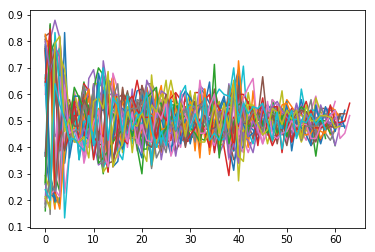

In [38]:
import matplotlib.pyplot as plt

for k in predictions_at_time:
    x_pred = []
    x_opp = []
    x
    for i in k:
        if i[1] == 1:
            x_pred.append(i[0][1][0][0])
            x_opp.append(i[0][1][0][1])
        else:
            x_pred.append(i[0][1][0][1])
            x_opp.append(i[0][1][0][0])

    plt.plot(x_pred)

This plot shows the predicted probabilities for all thirty NBA teams as their season progresses. Most of the teams see a lot of fluctuation depending on the difficulty of their schedules. What we can deduce from this chart is the high level of randomness in game winners. As the season goes forward, it becomes harder and harder to determine whether or not a team will win. 



## Conclusion

In a future project, I would love to consider the effects of individual players in my model. While the historical version of this data wasn't available on basketball-reference, it was available on stats.nba.com. I wanted all my work to be original, so I didn't use an API to collect that data for this project. Not including the effects of individual players definitely has an impact on the performance of prediction at different points of the season. It would be awesome if I could take into account the fact that players get traded before the trade deadline or if players miss games due to injury. 

I really enjoyed working on this project. Predicting basketball games turned out to be much more of a challenge than I had originally expected- but I relish challenges, and this is something I will definitely return to to see if I can come up with something more powerful!